In [ ]:
import numpy as np
import random
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# HYPERPARAMETERS
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
GENERATOR_NUM_FEATURES = 100
GENERATOR_HIDDEN_SIZE, DISCRIMINATOR_HIDDEN_SIZE = 128, 128
NUM_EPOCHS = 100
DROPOUT_PROB = 0.4

device = 'cuda'

In [ ]:
# class Generator(nn.Module):

#   def __init__(self, input_size, hidden_dim):
#     super(Generator, self).__init__()
#     output_size = 28 * 28

#     self.out = nn.Sequential(
#       nn.Linear(input_size, hidden_dim),
#       nn.LeakyReLU(0.2),
#       # nn.Dropout(DROPOUT_PROB),
#       nn.Linear(hidden_dim, 2*hidden_dim),
#       nn.LeakyReLU(0.2),
#       # nn.Dropout(DROPOUT_PROB),
#       nn.Linear(2*hidden_dim, 4*hidden_dim),
#       nn.LeakyReLU(0.2),
#       # nn.Dropout(DROPOUT_PROB),
#       nn.Linear(4*hidden_dim, output_size),
#       nn.Tanh()
#     )

#   def forward(self, x):
#     return self.out(x)


# class Discriminator(nn.Module):

#   def __init__(self, hidden_dim):
#     super(Discriminator, self).__init__()
#     input_size = 28 * 28
#     output_size = 1
    
#     self.out = nn.Sequential(
#         nn.Linear(input_size, 4*hidden_dim),
#         nn.LeakyReLU(0.2),  
#         nn.Dropout(DROPOUT_PROB),
#         nn.Linear(4*hidden_dim, 2*hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Dropout(DROPOUT_PROB),
#         nn.Linear(2*hidden_dim, hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Dropout(DROPOUT_PROB),
#         nn.Linear(hidden_dim, output_size)
#     )
      
      
#   def forward(self, x):
#     # flatten image
#     x = x.view(-1, 28*28)
#     return self.out(x)

# D = Discriminator(DISCRIMINATOR_HIDDEN_SIZE)
# G = Generator(GENERATOR_NUM_FEATURES, GENERATOR_HIDDEN_SIZE)
# print(D)
# print(G)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        #self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        #x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        #x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        #x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        #self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        #x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        #x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

D = Discriminator()
G = Generator()

#Sanity check of the model instances
print(D)
print(G)

#Passing to the GPU
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv4): ConvTranspose2d(32, 1, 

In [ ]:
def mnist_data():
  compose = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((.5), (.5))
      ])
  out_dir = './dataset'
  return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

data = mnist_data()
# train_data = torch.utils.data.Subset(data, random.sample(range(0, len(data)), 10000))

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

num_batches = len(data_loader)
print("Number of batches = {} with batch size = {}".format(num_batches, BATCH_SIZE))

Number of batches = 469 with batch size = 128


In [ ]:
# Calculate losses
def real_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.ones(batch_size).to(device) # real labels = 1
  # numerically stable loss
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size).to(device) # fake labels = 0
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

def calc_real_acc(D_out):
  labels = torch.ones(D_out.size()[0]).to(device) # real labels = 1
  # print("real", D_out.squeeze()[:10])
  correct_pred = ((D_out.squeeze() >= 0.5) == labels).float().sum()
  return correct_pred.item()

def calc_fake_acc(D_out):
  labels = torch.zeros(D_out.size()[0]).to(device) # fake labels = 0
  # print("fake", D_out.squeeze()[:10])
  correct_pred = ((D_out.squeeze() >= 0.5) == labels).float().sum()
  return correct_pred.item()

def sample_input(batch_size=-1):
  if batch_size != -1:
    return torch.normal(mean=torch.zeros((batch_size, GENERATOR_NUM_FEATURES)),
                      std = torch.ones((batch_size, GENERATOR_NUM_FEATURES)))
  else:
    return torch.normal(mean=torch.zeros(GENERATOR_NUM_FEATURES),
                        std = torch.ones(GENERATOR_NUM_FEATURES))
    
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 25
fixed_z = sample_input(sample_size).to(device)

d_optimizer = optim.Adam(D.parameters(), LEARNING_RATE)
g_optimizer = optim.Adam(G.parameters(), LEARNING_RATE)

In [ ]:
# keep track of loss and generated, "fake" samples
samples = []
losses = []
real_acc, fake_acc = [], []

print_every = 60000 // BATCH_SIZE + 1

# train the network
D.train()
G.train()
for epoch in range(NUM_EPOCHS):
  real_count, fake_count = 0, 0
  for batch_i, (real_images, _) in enumerate(data_loader):
        
    batch_size = real_images.size(0)
    real_images = real_images.to(device)

    # Generate fake images
    z = sample_input(batch_size).to(device)

    # calculate discriminator accuracy with generated fakes
    D.eval()
    G.eval()
    fake_images = G(z)
    real_count += calc_real_acc(D(real_images))
    fake_count_in_batch = calc_fake_acc(D(fake_images))
    fake_count += fake_count_in_batch
    G.train()
    D.train()
  
    # TRAIN THE DISCRIMINATOR
    d_optimizer.zero_grad()
    
    # 1. Train with real images

    # Compute the discriminator losses on real images 
    # smooth the real labels
    D_real = D(real_images)
    d_real_loss = real_loss(D_real)
    
    # 2. Train with fake images
    
    # Compute the discriminator losses on fake images
    fake_images = G(z)        
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)

    d_loss = d_real_loss

    # if (epoch <= 20) or (epoch > 20 and epoch % 2 == 0):
    # if epoch < 20 or fake_count_in_batch <= 0.99 * batch_size:
      # add up loss and perform backprop
    # if batch_i % 2 == 0:
    d_loss += d_fake_loss

    d_loss.backward()
    d_optimizer.step()
  
    # TRAIN THE GENERATOR
    g_optimizer.zero_grad()
    
    # 1. Train with fake images and flipped labels
    
    # Generate fake images
    z = sample_input(batch_size).to(device)
    fake_images = G(z)
    
    # Compute the discriminator losses on fake images 
    # using flipped labels!
    D_fake = D(fake_images)
    g_loss = real_loss(D_fake) # use real loss to flip labels

    # if fake_count_in_batch >= 0.2 * batch_size:
      # perform backprop
    g_loss.backward()
    g_optimizer.step()

    # Print some loss stats
    if batch_i % print_every == 0:
        # print discriminator and generator loss
        print('Epoch [{:5d}/{:5d}]'.format(epoch+1, NUM_EPOCHS))
        print("\td_real_loss: {:6.4f} | d_fake_loss: {:6.4f} | g_loss: {:6.4f}".format(d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        print("\td_fake_acc: {:6.4f} | d_real_acc: {:6.4f}".format(fake_count/batch_size, real_count/batch_size))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
  losses.append((d_real_loss.item() + d_fake_loss.item(), g_loss.item()))
  real_acc.append(real_count/60000)
  fake_acc.append(fake_count/60000)
  
  # generate and save sample, fake images
  G.eval() # eval mode for generating samples
  samples_z = G(fixed_z)
  samples.append(samples_z)
  # if epoch % 5 == 0:
    # view_samples(samples_z, epoch+90)
  G.train() # back to train mode

Epoch [    1/  100]
	d_real_loss: 1.3879 | d_fake_loss: 0.6890 | g_loss: 0.6912
	d_fake_acc: 1.0000 | d_real_acc: 0.0000
Epoch [    2/  100]
	d_real_loss: 0.5072 | d_fake_loss: 0.2229 | g_loss: 3.0472
	d_fake_acc: 0.9922 | d_real_acc: 0.9297
Epoch [    3/  100]
	d_real_loss: 0.7371 | d_fake_loss: 0.3526 | g_loss: 2.3633
	d_fake_acc: 0.9844 | d_real_acc: 0.9062
Epoch [    4/  100]
	d_real_loss: 1.0950 | d_fake_loss: 0.4594 | g_loss: 1.2285
	d_fake_acc: 0.9141 | d_real_acc: 0.6406
Epoch [    5/  100]
	d_real_loss: 0.7832 | d_fake_loss: 0.3612 | g_loss: 1.5870
	d_fake_acc: 0.9766 | d_real_acc: 0.8125
Epoch [    6/  100]
	d_real_loss: 1.0054 | d_fake_loss: 0.4904 | g_loss: 1.2766
	d_fake_acc: 0.9219 | d_real_acc: 0.7188
Epoch [    7/  100]
	d_real_loss: 0.8797 | d_fake_loss: 0.4796 | g_loss: 1.3112
	d_fake_acc: 0.9062 | d_real_acc: 0.8672
Epoch [    8/  100]
	d_real_loss: 0.9151 | d_fake_loss: 0.4337 | g_loss: 1.3762
	d_fake_acc: 0.9219 | d_real_acc: 0.7656
Epoch [    9/  100]
	d_real_loss

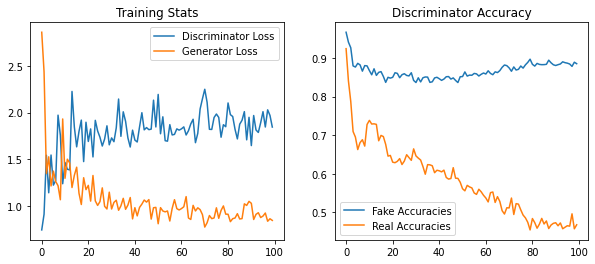

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
losses = np.array(losses)
ax1.plot(losses.T[0], label='Discriminator Loss')
ax1.plot(losses.T[1], label='Generator Loss')
ax1.set_title("Training Stats")
ax2.plot(fake_acc, label='Fake Accuracies')
ax2.plot(real_acc, label='Real Accuracies')
ax2.set_title("Discriminator Accuracy")
ax1.legend()
ax2.legend()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(samples, epoch):
    samples = samples.to('cpu')
    fig, axes = plt.subplots(figsize=(5,5), nrows=5, ncols=samples.size()[0]//5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.savefig('graphs/DCGAN Epoch ' + str(epoch) + '.png')

In [ ]:
# rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
# cols = 8
# fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

# for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
#     for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
#         img = img.detach().cpu()
#         ax.imshow(img.reshape((28,28)), cmap='Greys_r', vmax=1.0, vmin=-1.0)
#         ax.xaxis.set_visible(False)
#         ax.yaxis.set_visible(False)

In [ ]:
# fig, axes = plt.subplots(figsize=(7,3), nrows=1, ncols=cols, sharex=True, sharey=True)
# imgs = []

# for epoch, sample in enumerate(samples):
#   ims = []
#   ims.append(axes[0].text(cols//2, -0.5, "Epoch {}".format(epoch), transform=axes[0].transAxes))
#   for image, ax in zip(sample, axes):
#     image = image.detach().cpu()
#     im = ax.imshow(image.reshape((28,28)), cmap='Greys_r', vmax=1.0, vmin=-1.0, animated=True)
#     ims.append(im)
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#   imgs.append(ims)
  
# im_ani = animation.ArtistAnimation(fig, imgs, interval=50, repeat=False, blit=True)
# plt.close()
# HTML(im_ani.to_html5_video())

In [ ]:
G.eval()
# z = sample_input(25).to(device)
sample = G(fixed_z)
view_samples(sample)

TypeError: ignored